In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data load

In [34]:
try:
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_FULL_2021_Cleaned_Imputed.csv not found.")

Data loaded successfully with 252 rows (days) and 6540 assets.


In [35]:
data.head()

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMT,ASML,...,GRU,GSCE,GSP,HDLB,HMDCF,HOMU,HWCPZ,HAWLM,HBANP,HFRO-PA
0,125.974464,86.739708,99.687309,238.710358,485.339996,153.288055,92.300003,193.642502,191.466125,477.949158,...,3.5100,17.25,10.920,6.557615,5.1097,0.55,19.842388,15.62887,18.716362,19.115032
1,127.532021,87.636642,100.920723,240.069351,485.690002,152.861603,92.769997,194.582230,192.433868,483.072815,...,3.4950,17.25,11.430,6.720678,5.1097,0.55,19.909050,15.62887,18.716362,19.110727
2,123.239037,86.879608,100.710602,242.694153,466.309998,152.326324,90.330002,199.272491,187.359482,468.600525,...,3.5450,17.25,11.465,7.058459,5.1097,0.55,19.716475,15.62887,18.716362,19.087008
3,127.444374,87.809464,101.688164,244.983932,477.739990,153.188248,95.160004,199.930344,189.635117,479.316132,...,3.4501,17.25,11.490,7.087579,5.1097,0.55,19.894239,15.62887,18.716362,19.116274
4,128.544388,88.270248,101.971436,245.877502,485.100006,155.184143,94.580002,203.749222,193.733017,486.303741,...,3.5650,17.25,11.690,7.081756,5.1097,0.55,19.975708,15.62887,18.716362,19.026497


### Log returns

In [36]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


In [37]:
ANNUALIZATION_FACTOR = 252

daily_metrics = log_returns.agg(['mean', 'std'])

# 1. Аннуализация ожидаемой доходности (mu)
expected_returns = daily_metrics.loc['mean'] * ANNUALIZATION_FACTOR

# 2. Аннуализация риска (sigma)
annual_volatility = daily_metrics.loc['std'] * np.sqrt(ANNUALIZATION_FACTOR)

# Объединяем результаты в один DataFrame
asset_metrics = pd.DataFrame({
    'Expected Return (mu)': expected_returns,
    'Risk (sigma)': annual_volatility
})

# Сортировка для вывода
asset_metrics = asset_metrics.sort_values(by='Risk (sigma)', ascending=True)

print("Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.")
print("\n--- Top 5 lowest risk assets ---")
print(asset_metrics.head())
print("\n--- Bottom 5 highest risk assets ---")
print(asset_metrics.tail())

Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.

--- Top 5 lowest risk assets ---
      Expected Return (mu)  Risk (sigma)
UCIX              0.025199  6.035947e-18
WARM              0.025199  6.035947e-18
VCOR              0.025199  6.035947e-18
WBHC              0.025199  6.035947e-18
MULG              0.025199  6.035947e-18

--- Bottom 5 highest risk assets ---
      Expected Return (mu)  Risk (sigma)
EOSS             -5.658339     14.391406
ELIO             -2.452975     15.135011
SECI              0.931093     18.431838
APPB             -5.661648     18.724938
NDTP             -0.296223     20.401293


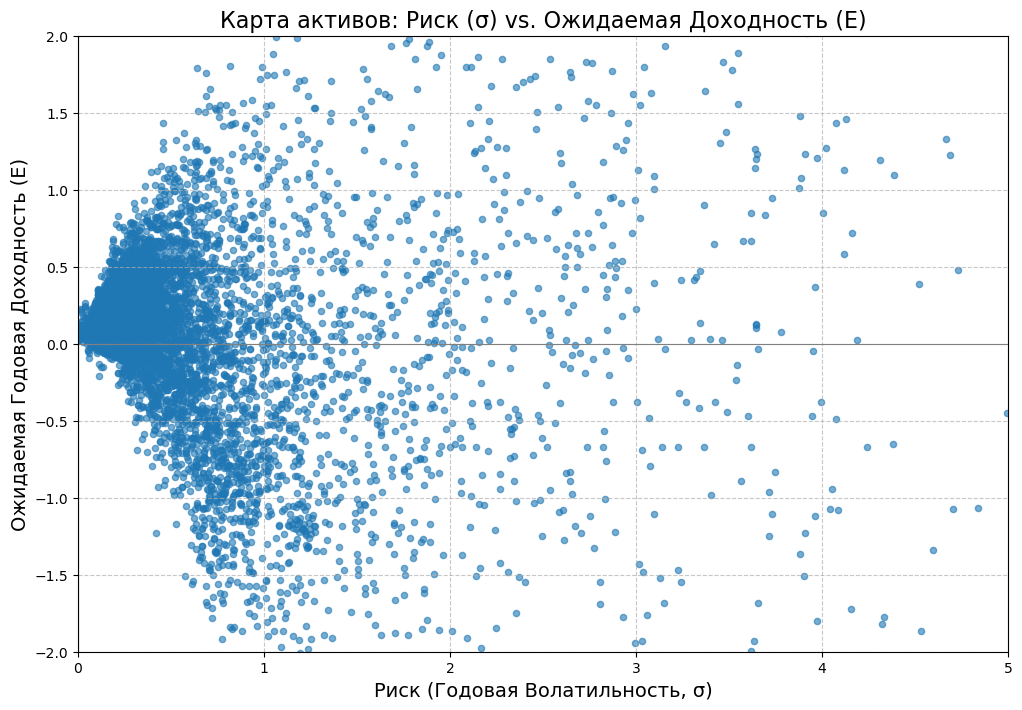

In [38]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.6,
    s=20
)

plt.title('Карта активов: Риск (σ) vs. Ожидаемая Доходность (E)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 5)
plt.ylim(-2, 2)

plt.axhline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевой доходности
plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевого риска

plt.show()

### Поиск Парето-оптимальных активов

In [39]:
df = asset_metrics.reset_index().rename(columns={'index': 'Ticker'})
df_sorted = df.sort_values(by='Risk (sigma)', ascending=True).reset_index(drop=True)

pareto_assets = []
max_return_so_far = -np.inf

for index, row in df_sorted.iterrows():
    current_return = row['Expected Return (mu)']

    # Актив Парето-оптимален, если его доходность строго выше
    # максимальной доходности, достигнутой при меньшем риске.
    if current_return > max_return_so_far:
        pareto_assets.append(row['Ticker'])
        max_return_so_far = current_return

# 3. Фильтрация DataFrame по Парето-оптимальным активам
pareto_df = asset_metrics.loc[pareto_assets]

print(f"\nTotal number of Pareto-Optimal Assets found: {len(pareto_assets)}")
print("\n--- Pareto-Optimal Assets (E, σ) ---")
print(pareto_df.head(10))


Total number of Pareto-Optimal Assets found: 32

--- Pareto-Optimal Assets (E, σ) ---
       Expected Return (mu)  Risk (sigma)
ELLKF              0.025199  6.035947e-18
XPTFX              0.043246  6.098673e-03
CCLFX              0.123407  9.506756e-03
NICHX              0.141159  1.149543e-02
PRDEX              0.223496  1.292281e-02
FROPX              0.267259  3.546448e-02
RSF                0.281760  9.812526e-02
PIIVX              0.322518  1.052297e-01
NRSZX              0.352706  1.055189e-01
CET                0.442299  1.216275e-01


Визуализируем Парето-оптимальные активы:

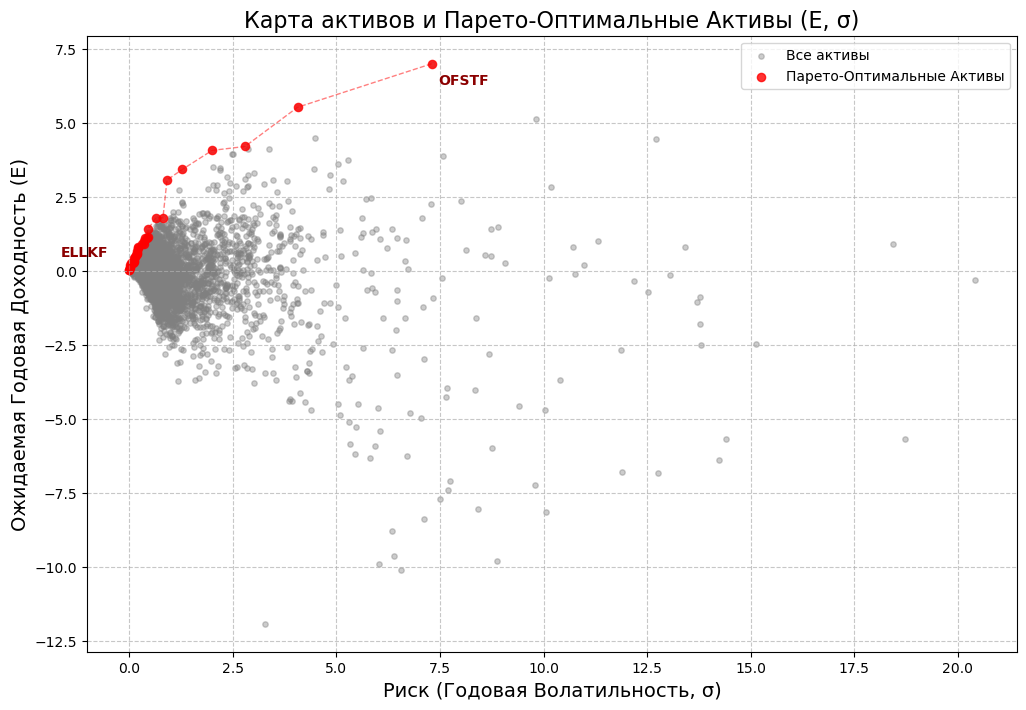

In [40]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

min_risk_asset = pareto_df.iloc[0]
max_return_asset = pareto_df.sort_values(by='Expected Return (mu)', ascending=False).iloc[0]

plt.annotate(
    min_risk_asset.name,
    (min_risk_asset['Risk (sigma)'], min_risk_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(-15, 10),
    ha='right',
    color='darkred',
    fontweight='bold'
)
plt.annotate(
    max_return_asset.name,
    (max_return_asset['Risk (sigma)'], max_return_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, -15),
    ha='left',
    color='darkred',
    fontweight='bold'
)


plt.title('Карта активов и Парето-Оптимальные Активы (E, σ)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Оценка VAR

In [41]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # Уровень значимости
PERCENTILE = ALPHA * 100 # перцентиль для поиска в распределении доходностей (5-й перцентиль)

pareto_log_returns = log_returns[pareto_assets]
var_daily_return = pareto_log_returns.quantile(ALPHA, axis=0)

# VaR - это ожидаемые потери (положительное число), поэтому берем отрицательное значение от доходности.
var_daily = -var_daily_return

# VaR_annual = VaR_daily * sqrt(T), как и стандартное отклонение
ANNUALIZATION_FACTOR = 252
var_annual = var_daily * np.sqrt(ANNUALIZATION_FACTOR)


# Объединяем VaR с метриками риска и доходности
pareto_df['VaR (Daily, 95%)'] = var_daily
pareto_df['VaR (Annual, 95%)'] = var_annual

pareto_df_sorted = pareto_df.sort_values(by='VaR (Annual, 95%)', ascending=True)

print(f"Calculated VaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual VaR ---")
print(pareto_df_sorted.head(10))

Calculated VaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual VaR ---
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  VaR (Annual, 95%)
ELLKF              0.025199  6.035947e-18         -0.000100          -0.001587
XPTFX              0.043246  6.098673e-03         -0.000100          -0.001587
CCLFX              0.123407  9.506756e-03         -0.000100          -0.001587
NICHX              0.141159  1.149543e-02         -0.000100          -0.001587
PRDEX              0.223496  1.292281e-02         -0.000100          -0.001587
FROPX              0.267259  3.546448e-02          0.001248           0.019817
PIIVX              0.322518  1.052297e-01          0.004458           0.070769
RSF                0.281760  9.812526e-02          0.007187           0.114098
NRSZX              0.352706  1.055189e-01          0.008387           0.133140
LTAFX              0.539107  1.641799e-01          0.008888           0.141099


In [42]:
# Наиболее предпочтительный актив по VaR - это актив с минимальным VaR.
# pareto_df_sorted уже отсортирован по возрастанию 'VaR (Annual, 95%)' (из cell 9),
# поэтому первый актив - наиболее предпочтительный.
most_preferred_asset = pareto_df_sorted.iloc[0]

ticker = most_preferred_asset.name
risk = most_preferred_asset['Risk (sigma)']
exp_return = most_preferred_asset['Expected Return (mu)']
daily_var = most_preferred_asset['VaR (Daily, 95%)']
annual_var = most_preferred_asset['VaR (Annual, 95%)']

print("--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---")
print(f"Тикер: {ticker}")
print(f"Годовой VaR (95%): {annual_var:.4f}")
print(f"Годовой Риск (σ): {risk:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return:.4f}")

# Для поиска на карте активов:
print("\nРасположение на карте (σ, E):")
print(f"Риск (X-координата): {risk:.4f}")
print(f"Доходность (Y-координата): {exp_return:.4f}")

--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---
Тикер: ELLKF
Годовой VaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

Расположение на карте (σ, E):
Риск (X-координата): 0.0000
Доходность (Y-координата): 0.0252


In [43]:
data["HMDCF"].describe()

count    252.0000
mean       5.1097
std        0.0000
min        5.1097
25%        5.1097
50%        5.1097
75%        5.1097
max        5.1097
Name: HMDCF, dtype: float64

Это малоликвидный актив, цена которого даже не изменилась за целый год

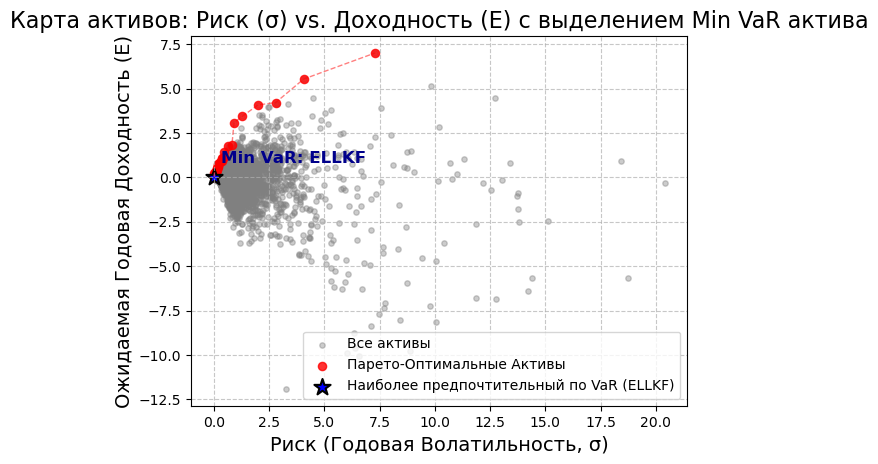

In [44]:
plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

plt.scatter(
    most_preferred_asset['Risk (sigma)'],
    most_preferred_asset['Expected Return (mu)'],
    alpha=1.0,
    s=150,
    color='blue',
    marker='*',
    edgecolors='black',
    linewidths=1.5,
    label=f'Наиболее предпочтительный по VaR ({most_preferred_asset.name})'
)

plt.annotate(
    f'Min VaR: {most_preferred_asset.name}',
    (most_preferred_asset['Risk (sigma)'], most_preferred_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, 10),
    ha='left',
    color='darkblue',
    fontweight='bold',
    fontsize=12
)


plt.title('Карта активов: Риск (σ) vs. Доходность (E) с выделением Min VaR актива', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Анализ CVaR

In [45]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # 0.05

pareto_log_returns = log_returns[pareto_assets]

# 2. Находим пороговое значение доходности (5-й перцентиль)
var_threshold = pareto_log_returns.quantile(ALPHA, axis=0)

# 3. Рассчитываем CVaR (Average of returns <= threshold)
cvar_daily = {}
for ticker in pareto_log_returns.columns:
    tail_returns = pareto_log_returns[ticker][pareto_log_returns[ticker] <= var_threshold[ticker]]

    # CVaR = - Среднее значение этих хвостов
    cvar_daily[ticker] = -tail_returns.mean()

cvar_daily_series = pd.Series(cvar_daily)

ANNUALIZATION_FACTOR = 252 # возьмём за год
cvar_annual_series = cvar_daily_series * np.sqrt(ANNUALIZATION_FACTOR)

pareto_df['CVaR (Daily, 95%)'] = cvar_daily_series
pareto_df['CVaR (Annual, 95%)'] = cvar_annual_series

pareto_df_cvar_sorted = pareto_df.sort_values(by='CVaR (Annual, 95%)', ascending=True)

print(f"Calculated CVaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---")
print(pareto_df_cvar_sorted[['Expected Return (mu)', 'Risk (sigma)', 'VaR (Annual, 95%)', 'CVaR (Annual, 95%)']].head(10))

Calculated CVaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---
       Expected Return (mu)  Risk (sigma)  VaR (Annual, 95%)  \
ELLKF              0.025199  6.035947e-18          -0.001587   
CCLFX              0.123407  9.506756e-03          -0.001587   
NICHX              0.141159  1.149543e-02          -0.001587   
XPTFX              0.043246  6.098673e-03          -0.001587   
PRDEX              0.223496  1.292281e-02          -0.001587   
FROPX              0.267259  3.546448e-02           0.019817   
PIIVX              0.322518  1.052297e-01           0.070769   
NRSZX              0.352706  1.055189e-01           0.133140   
LTAFX              0.539107  1.641799e-01           0.141099   
RSF                0.281760  9.812526e-02           0.114098   

       CVaR (Annual, 95%)  
ELLKF           -0.001587  
CCLFX           -0.001529  
NICHX           -0.000862  
XPTFX           -0.000838  
PRDEX           -0.000656  
FROPX            0.03686

In [46]:
# Наиболее предпочтительный актив по CVaR - это актив с минимальным CVaR (первый в отсортированном df)
most_preferred_asset_cvar = pareto_df_cvar_sorted.iloc[0]

ticker_cvar = most_preferred_asset_cvar.name
risk_cvar = most_preferred_asset_cvar['Risk (sigma)']
exp_return_cvar = most_preferred_asset_cvar['Expected Return (mu)']
annual_cvar = most_preferred_asset_cvar['CVaR (Annual, 95%)']

print("\n--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---")
print(f"Тикер: {ticker_cvar}")
print(f"Годовой CVaR (95%): {annual_cvar:.4f}")
print(f"Годовой Риск (σ): {risk_cvar:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return_cvar:.4f}")

# Для сравнения с VaR:
most_preferred_asset_var = pareto_df_sorted.iloc[0]

print("\n--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---")
print(f"Тикер, предпочтительный по VaR: {most_preferred_asset_var.name}")
print(f"Тикер, предпочтительный по CVaR: {ticker_cvar}")

if ticker_cvar == most_preferred_asset_var.name:
    print("Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.")
else:
    print("Вывод: Активы, минимизирующие VaR и CVaR, различаются. Это означает, что актив, минимизирующий CVaR, имеет более тонкий 'хвост' (меньше экстремальных потерь) по сравнению с активом, минимизирующим VaR.")


--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---
Тикер: ELLKF
Годовой CVaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---
Тикер, предпочтительный по VaR: ELLKF
Тикер, предпочтительный по CVaR: ELLKF
Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.


# Nasdaq100 analysis

Проделаем то же самое, но для более известных компаний из индекса Nasdaq100

In [47]:
try:
    data = pd.read_csv("data/processed/NASDAQ_100_2021_Cleaned.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_100_2021_Cleaned.csv not found.")

Data loaded successfully with 252 rows (days) and 100 assets.


In [48]:
data.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,VRTX,WBA,WBD,WDAY,XEL,ZS,AU10Y,BR10Y,CA10Y,CH10Y
0,"129,41","139,15","485,34","146,02","168,96","296,84","81,54","86,87","92,3","226,66",...,"229,43","41,4","30,63","228,08","65,655","196,09","0,99","6,86","0,677","2,8"
1,"131,01","148,3","485,69","148,63","168,49","301,7","81,43","89,6","92,77","227,76",...,"228,58","41,16","31,52","225,36","65,02","193,48","0,949","6,84","0,713","2,8"
2,"126,6","142,77","466,31","149,3","167,9","302,87","82,08","90,83","90,33","233,25",...,"226,65","43,03","34,25",220,"66,46","184,42","1,061","7,04","0,758","2,81"
3,"130,92","151,27","477,74","155,61","168,85","315,2","79,89","94,56","95,16","234,02",...,"232,9","45,26","34,4","226,21","65,16","193,05","1,058","7,27","0,794","2,83"
4,"132,05","149,77","485,1","156,74","171,05","319,85","79,18","95,56","94,58","238,49",...,237,"45,21","34,63","227,65","65,76","197,37","1,096","7,57","0,815","2,85"


In [49]:
data = data.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)

C:\Users\n.maryakhin\AppData\Local\Temp\ipykernel_14552\3109654890.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)


In [50]:
data.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,VRTX,WBA,WBD,WDAY,XEL,ZS,AU10Y,BR10Y,CA10Y,CH10Y
0,129.41,139.15,485.34,146.02,168.96,296.84,81.54,86.87,92.3,226.66,...,229.43,41.4,30.63,228.08,65.655,196.09,0.99,6.86,0.677,2.8
1,131.01,148.3,485.69,148.63,168.49,301.7,81.43,89.6,92.77,227.76,...,228.58,41.16,31.52,225.36,65.02,193.48,0.949,6.84,0.713,2.8
2,126.6,142.77,466.31,149.3,167.9,302.87,82.08,90.83,90.33,233.25,...,226.65,43.03,34.25,220,66.46,184.42,1.061,7.04,0.758,2.81
3,130.92,151.27,477.74,155.61,168.85,315.2,79.89,94.56,95.16,234.02,...,232.9,45.26,34.4,226.21,65.16,193.05,1.058,7.27,0.794,2.83
4,132.05,149.77,485.1,156.74,171.05,319.85,79.18,95.56,94.58,238.49,...,237,45.21,34.63,227.65,65.76,197.37,1.096,7.57,0.815,2.85


In [51]:
data = data.astype(float)

In [52]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


In [53]:
ANNUALIZATION_FACTOR = 252

daily_metrics = log_returns.agg(['mean', 'std'])

expected_returns = daily_metrics.loc['mean'] * ANNUALIZATION_FACTOR
annual_volatility = daily_metrics.loc['std'] * np.sqrt(ANNUALIZATION_FACTOR)
asset_metrics = pd.DataFrame({
    'Expected Return (mu)': expected_returns,
    'Risk (sigma)': annual_volatility
})

asset_metrics = asset_metrics.sort_values(by='Risk (sigma)', ascending=True)

print("Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.")
print("\n--- Top 5 lowest risk assets ---")
print(asset_metrics.head())
print("\n--- Bottom 5 highest risk assets ---")
print(asset_metrics.tail())

Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.

--- Top 5 lowest risk assets ---
      Expected Return (mu)  Risk (sigma)
PEP               0.211622      0.145204
MDLZ              0.161003      0.158197
AEP               0.112744      0.165648
KDP               0.180086      0.175725
EXC               0.365102      0.181067

--- Bottom 5 highest risk assets ---
      Expected Return (mu)  Risk (sigma)
MDB               0.439365      0.601486
DASH              0.092917      0.651467
PDD              -1.029932      0.701593
TTD               0.195500      0.707224
MRNA              0.849591      0.803887


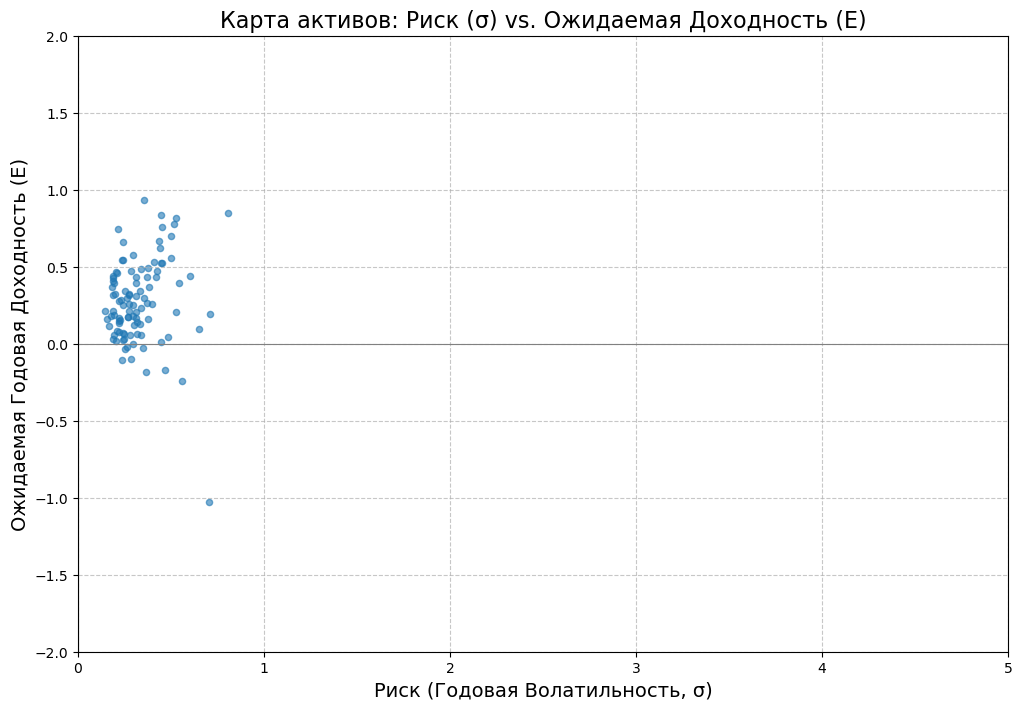

In [54]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.6,
    s=20
)

plt.title('Карта активов: Риск (σ) vs. Ожидаемая Доходность (E)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 5)
plt.ylim(-2, 2)

plt.axhline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевой доходности
plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевого риска

plt.show()

In [55]:
df = asset_metrics.reset_index().rename(columns={'index': 'Ticker'})
df_sorted = df.sort_values(by='Risk (sigma)', ascending=True).reset_index(drop=True)

pareto_assets = []
max_return_so_far = -np.inf

for index, row in df_sorted.iterrows():
    current_return = row['Expected Return (mu)']

    # Актив Парето-оптимален, если его доходность строго выше
    # максимальной доходности, достигнутой при меньшем риске.
    if current_return > max_return_so_far:
        pareto_assets.append(row['Ticker'])
        max_return_so_far = current_return

# 3. Фильтрация DataFrame по Парето-оптимальным активам
pareto_df = asset_metrics.loc[pareto_assets]

print(f"\nTotal number of Pareto-Optimal Assets found: {len(pareto_assets)}")
print("\n--- Pareto-Optimal Assets (E, σ) ---")
print(pareto_df.head(10))


Total number of Pareto-Optimal Assets found: 7

--- Pareto-Optimal Assets (E, σ) ---
       Expected Return (mu)  Risk (sigma)
PEP                0.211622      0.145204
EXC                0.365102      0.181067
ADP                0.404693      0.187943
PAYX               0.439326      0.188155
ORLY               0.468827      0.204702
CH10Y              0.742325      0.216287
FTNT               0.932563      0.352902


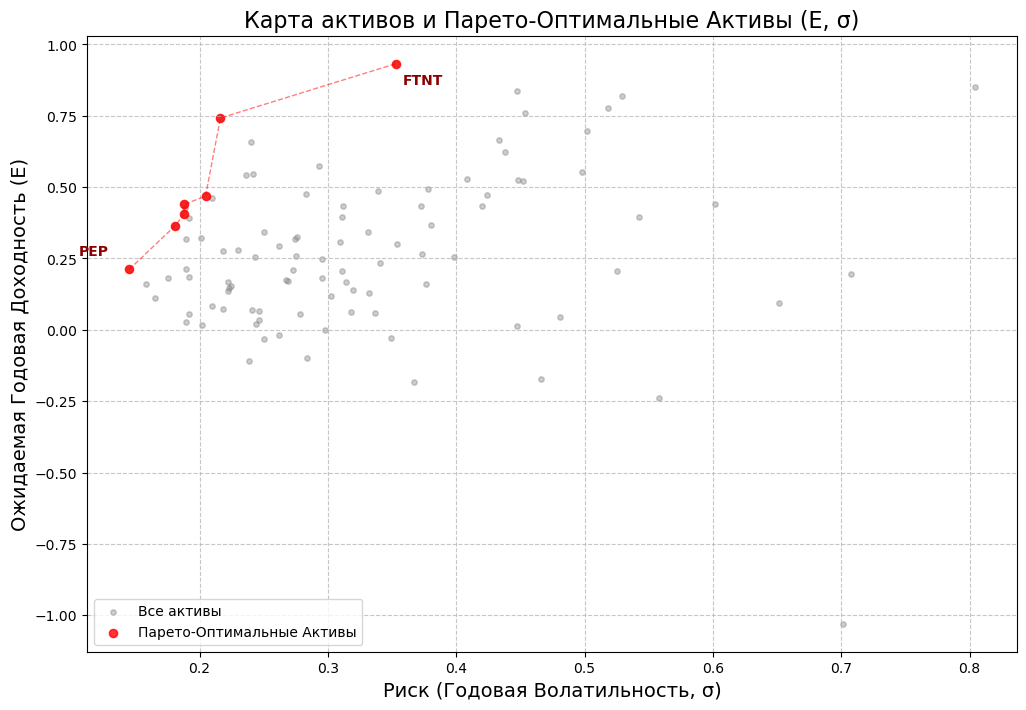

In [56]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

min_risk_asset = pareto_df.iloc[0]
max_return_asset = pareto_df.sort_values(by='Expected Return (mu)', ascending=False).iloc[0]

plt.annotate(
    min_risk_asset.name,
    (min_risk_asset['Risk (sigma)'], min_risk_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(-15, 10),
    ha='right',
    color='darkred',
    fontweight='bold'
)
plt.annotate(
    max_return_asset.name,
    (max_return_asset['Risk (sigma)'], max_return_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, -15),
    ha='left',
    color='darkred',
    fontweight='bold'
)


plt.title('Карта активов и Парето-Оптимальные Активы (E, σ)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [57]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # Уровень значимости
PERCENTILE = ALPHA * 100 # перцентиль для поиска в распределении доходностей (5-й перцентиль)

pareto_log_returns = log_returns[pareto_assets]
var_daily_return = pareto_log_returns.quantile(ALPHA, axis=0)

# VaR - это ожидаемые потери (положительное число), поэтому берем отрицательное значение от доходности.
var_daily = -var_daily_return

# VaR_annual = VaR_daily * sqrt(T), как и стандартное отклонение
ANNUALIZATION_FACTOR = 252
var_annual = var_daily * np.sqrt(ANNUALIZATION_FACTOR)


# Объединяем VaR с метриками риска и доходности
pareto_df['VaR (Daily, 95%)'] = var_daily
pareto_df['VaR (Annual, 95%)'] = var_annual

pareto_df_sorted = pareto_df.sort_values(by='VaR (Annual, 95%)', ascending=True)

print(f"Calculated VaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual VaR ---")
print(pareto_df_sorted.head(10))

Calculated VaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual VaR ---
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  VaR (Annual, 95%)
PEP                0.211622      0.145204          0.015773           0.250387
EXC                0.365102      0.181067          0.015817           0.251094
ORLY               0.468827      0.204702          0.016939           0.268891
PAYX               0.439326      0.188155          0.018438           0.292692
ADP                0.404693      0.187943          0.019289           0.306201
CH10Y              0.742325      0.216287          0.020502           0.325453
FTNT               0.932563      0.352902          0.035703           0.566766


In [58]:
# Наиболее предпочтительный актив по VaR - это актив с минимальным VaR.
# pareto_df_sorted уже отсортирован по возрастанию 'VaR (Annual, 95%)' (из cell 9),
# поэтому первый актив - наиболее предпочтительный.
most_preferred_asset = pareto_df_sorted.iloc[0]

ticker = most_preferred_asset.name
risk = most_preferred_asset['Risk (sigma)']
exp_return = most_preferred_asset['Expected Return (mu)']
daily_var = most_preferred_asset['VaR (Daily, 95%)']
annual_var = most_preferred_asset['VaR (Annual, 95%)']

print("--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---")
print(f"Тикер: {ticker}")
print(f"Годовой VaR (95%): {annual_var:.4f}")
print(f"Годовой Риск (σ): {risk:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return:.4f}")

# Для поиска на карте активов:
print("\nРасположение на карте (σ, E):")
print(f"Риск (X-координата): {risk:.4f}")
print(f"Доходность (Y-координата): {exp_return:.4f}")

--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---
Тикер: PEP
Годовой VaR (95%): 0.2504
Годовой Риск (σ): 0.1452
Ожидаемая Годовая Доходность (E): 0.2116

Расположение на карте (σ, E):
Риск (X-координата): 0.1452
Доходность (Y-координата): 0.2116


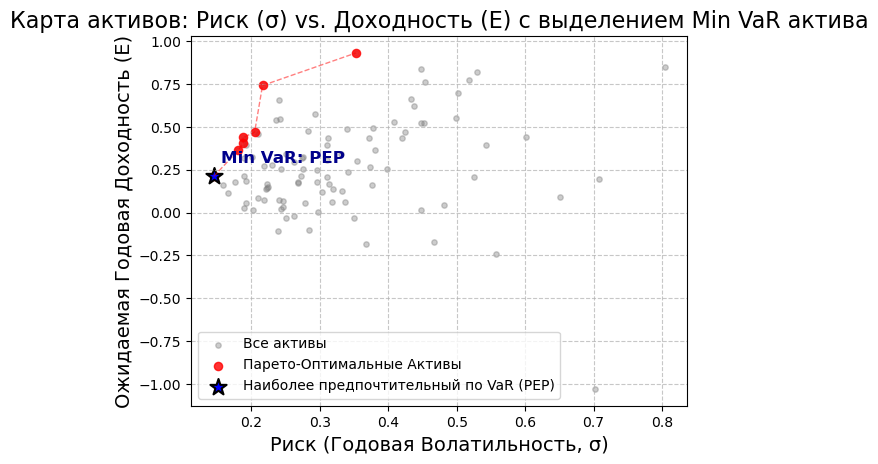

In [59]:
plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

plt.scatter(
    most_preferred_asset['Risk (sigma)'],
    most_preferred_asset['Expected Return (mu)'],
    alpha=1.0,
    s=150,
    color='blue',
    marker='*',
    edgecolors='black',
    linewidths=1.5,
    label=f'Наиболее предпочтительный по VaR ({most_preferred_asset.name})'
)

plt.annotate(
    f'Min VaR: {most_preferred_asset.name}',
    (most_preferred_asset['Risk (sigma)'], most_preferred_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, 10),
    ha='left',
    color='darkblue',
    fontweight='bold',
    fontsize=12
)


plt.title('Карта активов: Риск (σ) vs. Доходность (E) с выделением Min VaR актива', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [60]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # 0.05

pareto_log_returns = log_returns[pareto_assets]

# 2. Находим пороговое значение доходности (5-й перцентиль)
var_threshold = pareto_log_returns.quantile(ALPHA, axis=0)

# 3. Рассчитываем CVaR (Average of returns <= threshold)
cvar_daily = {}
for ticker in pareto_log_returns.columns:
    tail_returns = pareto_log_returns[ticker][pareto_log_returns[ticker] <= var_threshold[ticker]]

    # CVaR = - Среднее значение этих хвостов
    cvar_daily[ticker] = -tail_returns.mean()

cvar_daily_series = pd.Series(cvar_daily)

ANNUALIZATION_FACTOR = 252 # возьмём за год
cvar_annual_series = cvar_daily_series * np.sqrt(ANNUALIZATION_FACTOR)

pareto_df['CVaR (Daily, 95%)'] = cvar_daily_series
pareto_df['CVaR (Annual, 95%)'] = cvar_annual_series

pareto_df_cvar_sorted = pareto_df.sort_values(by='CVaR (Annual, 95%)', ascending=True)

print(f"Calculated CVaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---")
print(pareto_df_cvar_sorted[['Expected Return (mu)', 'Risk (sigma)', 'VaR (Annual, 95%)', 'CVaR (Annual, 95%)']].head(10))

Calculated CVaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---
       Expected Return (mu)  Risk (sigma)  VaR (Annual, 95%)  \
PEP                0.211622      0.145204           0.250387   
PAYX               0.439326      0.188155           0.292692   
ADP                0.404693      0.187943           0.306201   
EXC                0.365102      0.181067           0.251094   
ORLY               0.468827      0.204702           0.268891   
CH10Y              0.742325      0.216287           0.325453   
FTNT               0.932563      0.352902           0.566766   

       CVaR (Annual, 95%)  
PEP              0.315924  
PAYX             0.388915  
ADP              0.401941  
EXC              0.417573  
ORLY             0.460438  
CH10Y            0.465842  
FTNT             0.723307  


In [61]:
# Наиболее предпочтительный актив по CVaR - это актив с минимальным CVaR (первый в отсортированном df)
most_preferred_asset_cvar = pareto_df_cvar_sorted.iloc[0]

ticker_cvar = most_preferred_asset_cvar.name
risk_cvar = most_preferred_asset_cvar['Risk (sigma)']
exp_return_cvar = most_preferred_asset_cvar['Expected Return (mu)']
annual_cvar = most_preferred_asset_cvar['CVaR (Annual, 95%)']

print("\n--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---")
print(f"Тикер: {ticker_cvar}")
print(f"Годовой CVaR (95%): {annual_cvar:.4f}")
print(f"Годовой Риск (σ): {risk_cvar:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return_cvar:.4f}")

# Для сравнения с VaR:
most_preferred_asset_var = pareto_df_sorted.iloc[0]

print("\n--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---")
print(f"Тикер, предпочтительный по VaR: {most_preferred_asset_var.name}")
print(f"Тикер, предпочтительный по CVaR: {ticker_cvar}")

if ticker_cvar == most_preferred_asset_var.name:
    print("Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.")
else:
    print("Вывод: Активы, минимизирующие VaR и CVaR, различаются. Это означает, что актив, минимизирующий CVaR, имеет более тонкий 'хвост' (меньше экстремальных потерь) по сравнению с активом, минимизирующим VaR.")


--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---
Тикер: PEP
Годовой CVaR (95%): 0.3159
Годовой Риск (σ): 0.1452
Ожидаемая Годовая Доходность (E): 0.2116

--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---
Тикер, предпочтительный по VaR: PEP
Тикер, предпочтительный по CVaR: PEP
Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.


In [64]:
selected_tickers = []

# 1. Технологический гигант - Apple
selected_tickers.append('AAPL')

# 2. Актив с минимальным VaR
min_var_ticker = pareto_df_sorted.index[0]
selected_tickers.append(min_var_ticker)

# 3. Актив с максимальной доходностью из Парето-оптимальных
max_return_ticker = pareto_df.sort_values('Expected Return (mu)', ascending=False).index[0]
if max_return_ticker not in selected_tickers:
    selected_tickers.append(max_return_ticker)

# 4. Еще один известный актив
if 'MSFT' in log_returns.columns and 'MSFT' not in selected_tickers:
    selected_tickers.append('MSFT')
elif 'GOOGL' in log_returns.columns and 'GOOGL' not in selected_tickers:
    selected_tickers.append('GOOGL')
else:
    for ticker in pareto_df.index:
        if ticker not in selected_tickers:
            selected_tickers.append(ticker)
            break

print("Выбранные для анализа активы:")
print("-" * 50)
for i, ticker in enumerate(selected_tickers, 1):
    if ticker in pareto_df.index:
        risk = pareto_df.loc[ticker, 'Risk (sigma)']
        ret = pareto_df.loc[ticker, 'Expected Return (mu)']
        var_daily = pareto_df.loc[ticker, 'VaR (Daily, 95%)'] if 'VaR (Daily, 95%)' in pareto_df.columns else None
        print(f"{i}. {ticker}:")
        print(f"   Риск (σ): {risk:.4f}")
        print(f"   Доходность (E): {ret:.4f}")
        if var_daily is not None:
            print(f"   VaR (дневной, 95%): {var_daily:.4f}")
    else:
        print(f"{i}. {ticker}: (не в Парето-оптимальных)")
    print()

Выбранные для анализа активы:
--------------------------------------------------
1. AAPL: (не в Парето-оптимальных)

2. PEP:
   Риск (σ): 0.1452
   Доходность (E): 0.2116
   VaR (дневной, 95%): 0.0158

3. FTNT:
   Риск (σ): 0.3529
   Доходность (E): 0.9326
   VaR (дневной, 95%): 0.0357

4. MSFT: (не в Парето-оптимальных)



РАСШИРЕННЫЙ АНАЛИЗ АКТИВОВ


AAPL:
  Наблюдений: 251
  Среднее: 0.001360
  Медиана: 0.001573
  Стд. откл.: 0.015752
  5% квантиль: -0.025885
  95% квантиль: 0.026572
  Коэф. вариации: 11.5791
  Асимметрия: -0.1251
  Эксцесс: 0.3650
  Shapiro-Wilk p-value: 0.1299
  Ljung-Box p-value (lag 10): 0.7079
  ACF(1): -0.0345
  ACF(5): -0.0960

  ВЫВОДЫ:
  - Признаки 'белого шума': ДА (по Ljung-Box)
  - Нормальность распределения: НЕ отвергается
  - Максимальная доходность: 0.052546
  - Минимальная доходность: -0.042462
  - Размах: 0.095009
  - Дней с ростом: 134 (53.4%)
  - Дней с падением: 117 (46.6%)


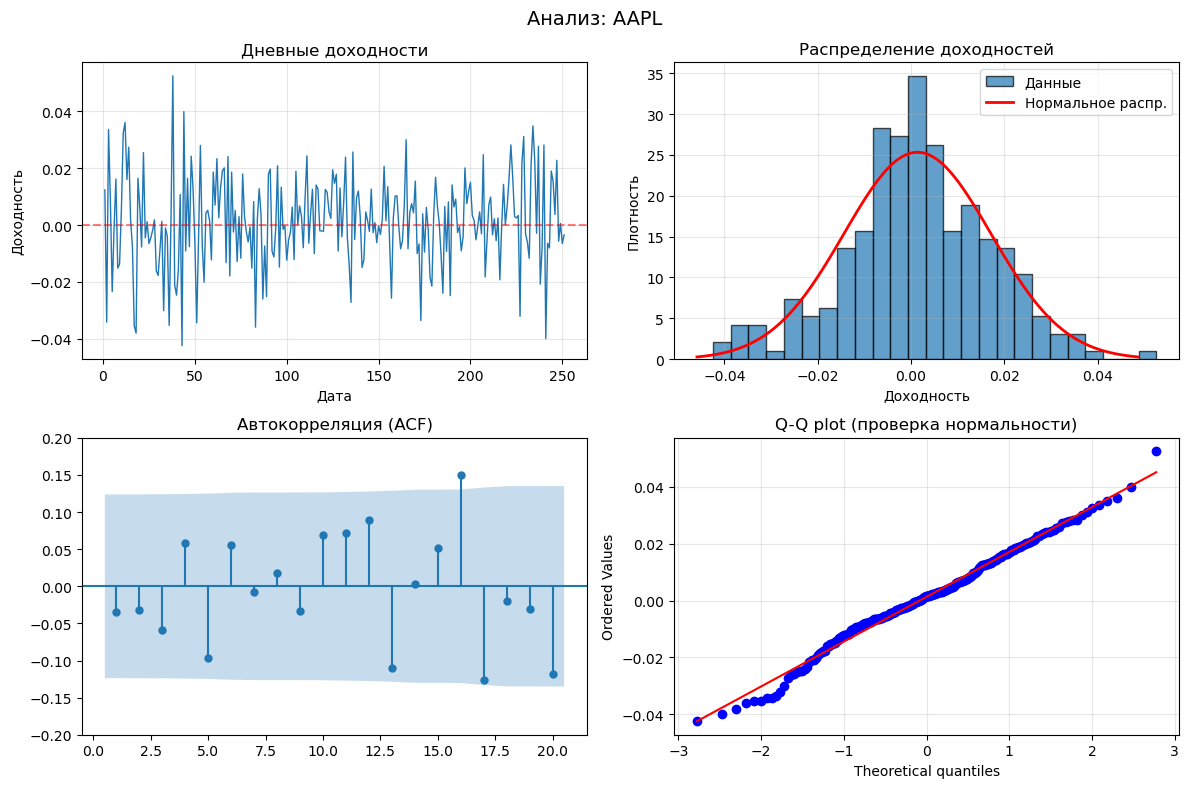



PEP:
  Наблюдений: 251
  Среднее: 0.000840
  Медиана: 0.000567
  Стд. откл.: 0.009147
  5% квантиль: -0.015773
  95% квантиль: 0.014474
  Коэф. вариации: 10.8923
  Асимметрия: -0.1070
  Эксцесс: 0.8888
  Shapiro-Wilk p-value: 0.0099
  Ljung-Box p-value (lag 10): 0.5192
  ACF(1): -0.0808
  ACF(5): 0.0633

  ВЫВОДЫ:
  - Признаки 'белого шума': ДА (по Ljung-Box)
  - Нормальность распределения: отвергается
  - Максимальная доходность: 0.032178
  - Минимальная доходность: -0.026819
  - Размах: 0.058997
  - Дней с ростом: 142 (56.6%)
  - Дней с падением: 109 (43.4%)


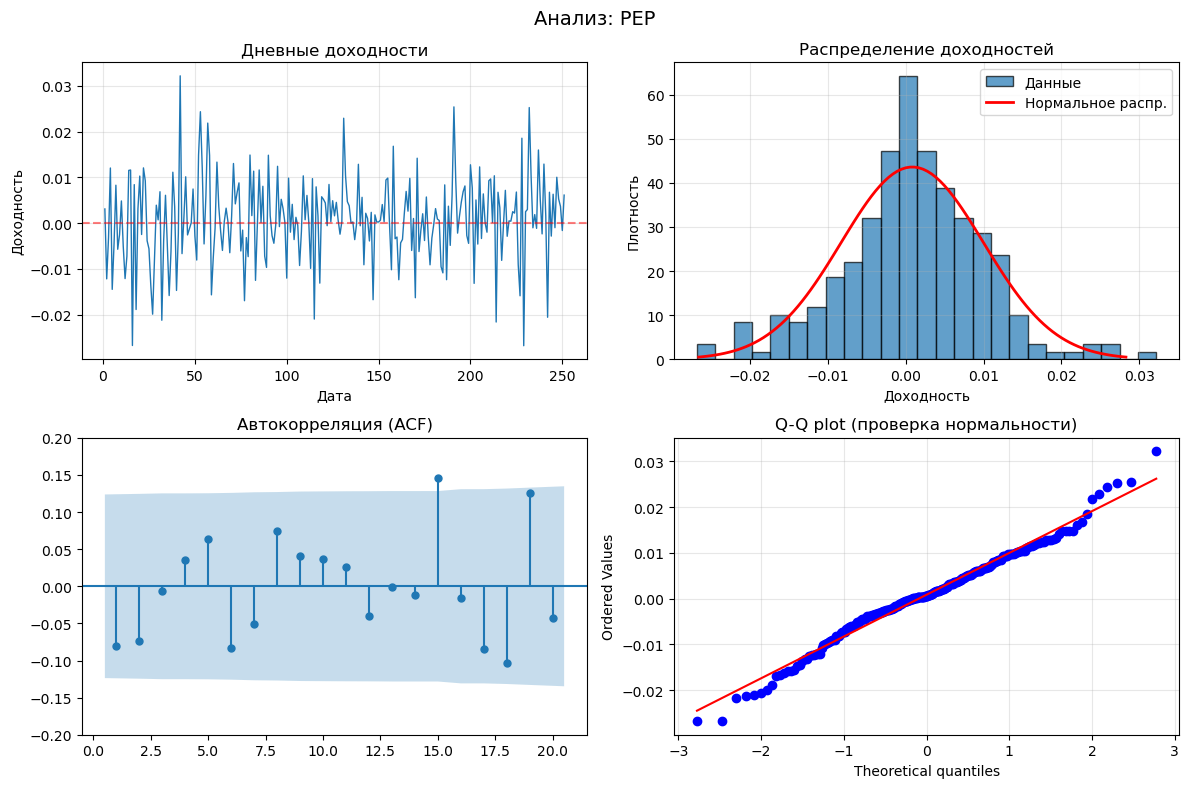



FTNT:
  Наблюдений: 251
  Среднее: 0.003701
  Медиана: 0.004626
  Стд. откл.: 0.022231
  5% квантиль: -0.035703
  95% квантиль: 0.036848
  Коэф. вариации: 6.0073
  Асимметрия: -0.1352
  Эксцесс: 1.2442
  Shapiro-Wilk p-value: 0.0186
  Ljung-Box p-value (lag 10): 0.3579
  ACF(1): -0.1046
  ACF(5): -0.0432

  ВЫВОДЫ:
  - Признаки 'белого шума': ДА (по Ljung-Box)
  - Нормальность распределения: отвергается
  - Максимальная доходность: 0.082860
  - Минимальная доходность: -0.084194
  - Размах: 0.167053
  - Дней с ростом: 150 (59.8%)
  - Дней с падением: 101 (40.2%)


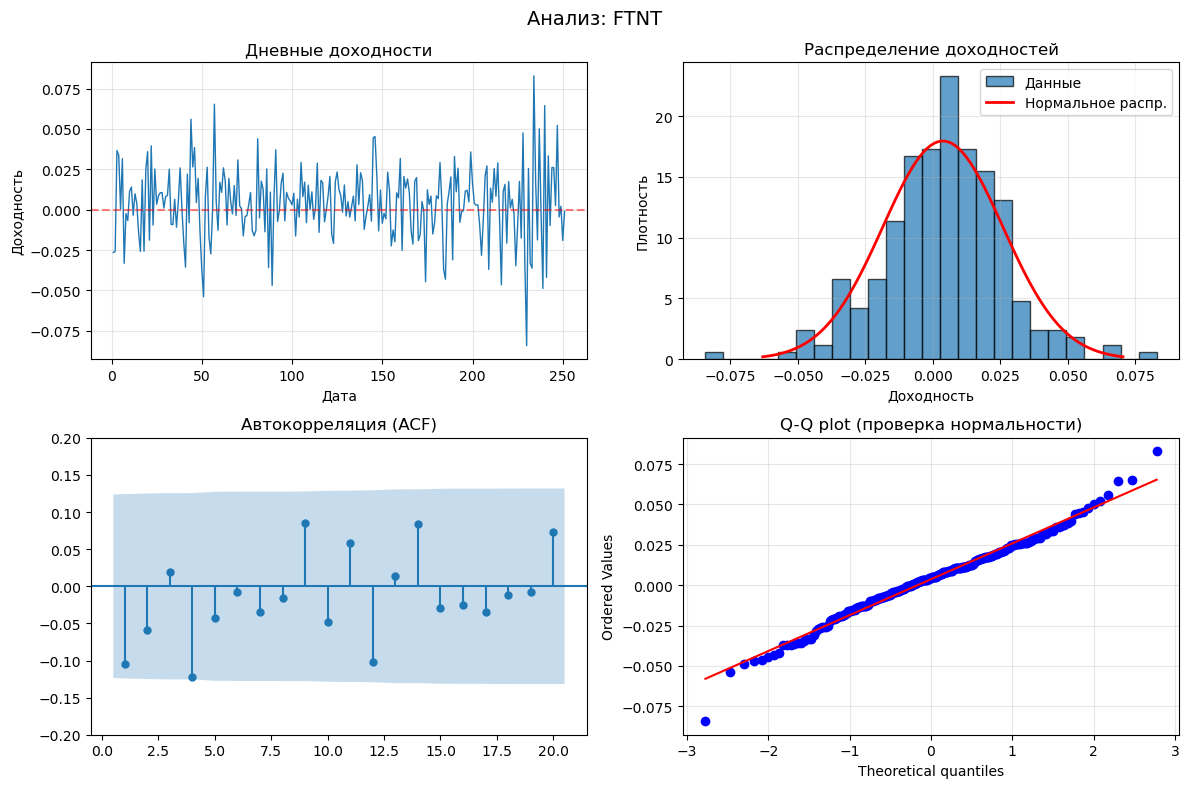



MSFT:
  Наблюдений: 251
  Среднее: 0.001833
  Медиана: 0.000885
  Стд. откл.: 0.013190
  5% квантиль: -0.020934
  95% квантиль: 0.023653
  Коэф. вариации: 7.1965
  Асимметрия: -0.0589
  Эксцесс: 0.3531
  Shapiro-Wilk p-value: 0.0502
  Ljung-Box p-value (lag 10): 0.8942
  ACF(1): -0.0591
  ACF(5): -0.0548

  ВЫВОДЫ:
  - Признаки 'белого шума': ДА (по Ljung-Box)
  - Нормальность распределения: НЕ отвергается
  - Максимальная доходность: 0.041347
  - Минимальная доходность: -0.036771
  - Размах: 0.078119
  - Дней с ростом: 134 (53.4%)
  - Дней с падением: 117 (46.6%)


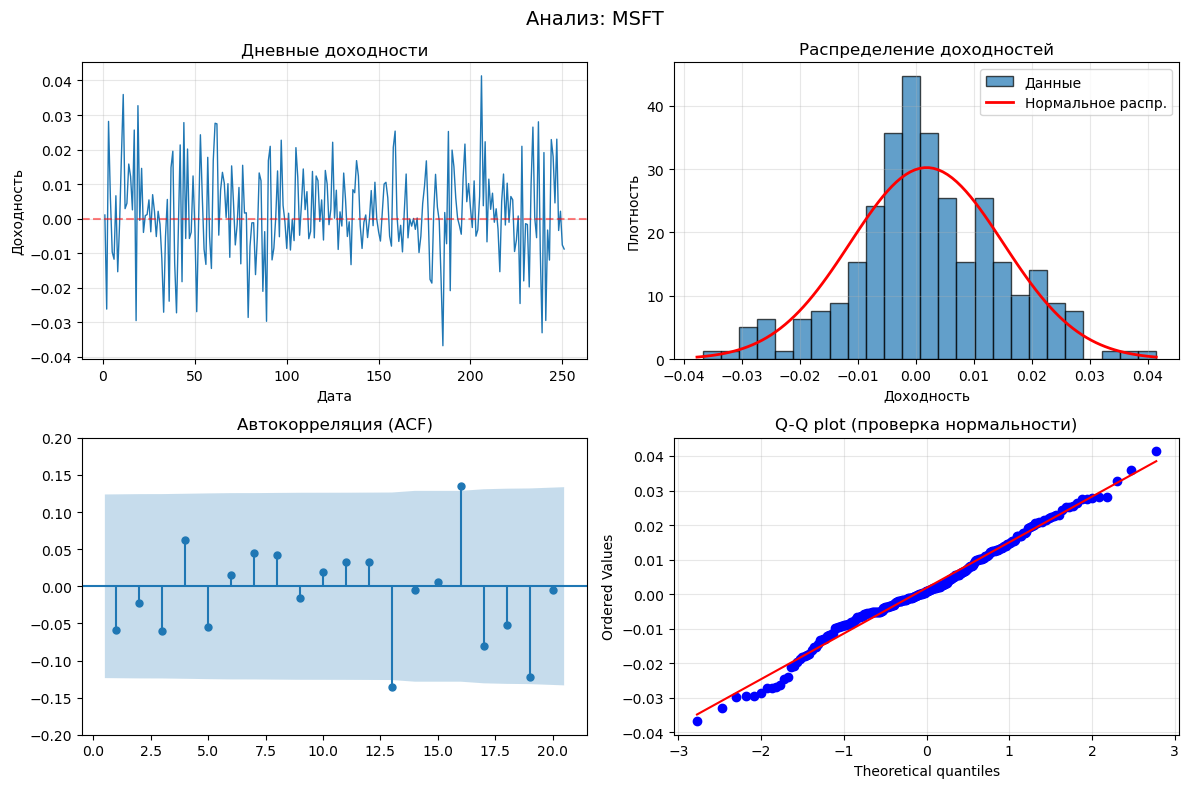


СВОДНАЯ СТАТИСТИКА ПО ВСЕМ АКТИВАМ

Основные статистические показатели:
          mean       std  data_range
AAPL  0.001360  0.015752    0.095009
PEP   0.000840  0.009147    0.058997
FTNT  0.003701  0.022231    0.167053
MSFT  0.001833  0.013190    0.078119

Активов с признаками белого шума (p > 0.05): 4 из 4

Среднее количество дней:
  - С ростом: 140.0 (55.6% от года)
  - С падением: 111.0 (44.0% от года)

Топ-4 самых волатильных активов:
  1. FTNT: std=0.022231, размах=0.167053
  2. AAPL: std=0.015752, размах=0.095009
  3. MSFT: std=0.013190, размах=0.078119
  4. PEP: std=0.009147, размах=0.058997

Анализ средних доходностей:
  - С положительной средней доходностью: 4 активов
  - С отрицательной средней доходностью: 0 активов
  - С нулевой средней доходностью: 0 активов

  Топ-4 по средней доходности:
    1. FTNT: 0.003701
    2. MSFT: 0.001833
    3. AAPL: 0.001360
    4. PEP: 0.000840

Анализ асимметрии распределения:
  - Правосторонняя асимметрия (>0.1): 0 активов
  - Левосторонн

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox






def simple_analysis(ticker, returns_series):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Анализ: {ticker}', fontsize=14)
    
    # Проверяем, достаточно ли изменчивости в данных
    data_range = returns_series.max() - returns_series.min()
    is_constant_data = data_range < 1e-10  # Практически постоянные данные
    
    # 1. График доходностей
    axes[0, 0].plot(returns_series.index, returns_series.values, linewidth=1)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Дневные доходности')
    axes[0, 0].set_xlabel('Дата')
    axes[0, 0].set_ylabel('Доходность')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Гистограмма с нормальным распределением
    mu, std = returns_series.mean(), returns_series.std()
    axes[0, 1].hist(returns_series, bins=25, density=True, 
                    edgecolor='black', alpha=0.7, label='Данные')
    
    # Добавляем кривую нормального распределения только если есть изменчивость
    if not is_constant_data and std > 0:
        x = np.linspace(mu - 3*std, mu + 3*std, 100)
        y = stats.norm.pdf(x, mu, std)
        axes[0, 1].plot(x, y, 'r-', linewidth=2, label='Нормальное распр.')
    
    axes[0, 1].set_title('Распределение доходностей')
    axes[0, 1].set_xlabel('Доходность')
    axes[0, 1].set_ylabel('Плотность')
    if not is_constant_data and std > 0:
        axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. ACF
    try:
        plot_acf(returns_series, lags=20, alpha=0.05, ax=axes[1, 0], zero=False)
        axes[1, 0].set_title('Автокорреляция (ACF)')
        axes[1, 0].set_ylim(-0.2, 0.2)
    except Exception as e:
        axes[1, 0].text(0.5, 0.5, f'ACF не доступна\n{str(e)}', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
    
    # 4. Q-Q plot для проверки нормальности (только если есть изменчивость)
    if not is_constant_data and data_range > 0:
        try:
            stats.probplot(returns_series, dist="norm", plot=axes[1, 1])
            axes[1, 1].set_title('Q-Q plot (проверка нормальности)')
            axes[1, 1].grid(True, alpha=0.3)
        except Exception as e:
            # Запасной вариант
            axes[1, 1].scatter(returns_series[:-1], returns_series[1:], alpha=0.5, s=10)
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
            axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
            axes[1, 1].set_title('Доходность(t) vs Доходность(t-1)')
            axes[1, 1].set_xlabel('Доходность(t-1)')
            axes[1, 1].set_ylabel('Доходность(t)')
            axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Q-Q plot недоступен\n(недостаточно изменчивости)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Недостаточно данных для Q-Q plot')
    
    plt.tight_layout()
    
    # РАСШИРЕННЫЙ СТАТИСТИЧЕСКИЙ АНАЛИЗ
    print(f"\n{ticker}:")
    print(f"  Наблюдений: {len(returns_series)}")
    print(f"  Среднее: {returns_series.mean():.6f}")
    print(f"  Медиана: {returns_series.median():.6f}")
    print(f"  Стд. откл.: {returns_series.std():.6f}")
    
    # Квантили
    print(f"  5% квантиль: {returns_series.quantile(0.05):.6f}")
    print(f"  95% квантиль: {returns_series.quantile(0.95):.6f}")
    
    # Вычисляем коэффициенты только если есть достаточно изменчивости
    if not is_constant_data and returns_series.std() > 0:
        # Коэффициент вариации
        cv = returns_series.std() / abs(returns_series.mean()) if returns_series.mean() != 0 else float('inf')
        print(f"  Коэф. вариации: {cv:.4f}")
        
        # Асимметрия и эксцесс с защитой от численных проблем
        try:
            skewness = stats.skew(returns_series)
            print(f"  Асимметрия: {skewness:.4f}")
        except Exception as e:
            print(f"  Асимметрия: N/A (ошибка: {str(e)})")
            skewness = None
        
        try:
            kurt = stats.kurtosis(returns_series)
            print(f"  Эксцесс: {kurt:.4f}")
        except Exception as e:
            print(f"  Эксцесс: N/A (ошибка: {str(e)})")
            kurt = None
    else:
        print(f"  Коэф. вариации: N/A (малая изменчивость)")
        print(f"  Асимметрия: N/A (малая изменчивость)")
        print(f"  Эксцесс: N/A (малая изменчивость)")
        skewness = None
        kurt = None
    
    # Проверка на нормальность (только если есть изменчивость)
    normal_test_p = None
    if not is_constant_data and returns_series.std() > 0:
        try:
            if len(returns_series) < 5000:
                shapiro_stat, shapiro_p = stats.shapiro(returns_series)
                print(f"  Shapiro-Wilk p-value: {shapiro_p:.4f}")
                normal_test_p = shapiro_p
            else:
                anderson_result = stats.anderson(returns_series, dist='norm')
                print(f"  Anderson-Darling stat: {anderson_result.statistic:.4f}")
        except Exception as e:
            print(f"  Тест нормальности: N/A ({str(e)})")
    else:
        print(f"  Тест нормальности: N/A (малая изменчивость)")
    
    # Тест Ljung-Box
    try:
        lb_test = acorr_ljungbox(returns_series, lags=[10], return_df=True)
        lb_pvalue = lb_test.loc[10, 'lb_pvalue']
        print(f"  Ljung-Box p-value (lag 10): {lb_pvalue:.4f}")
    except Exception as e:
        lb_pvalue = None
        print(f"  Ljung-Box: N/A ({str(e)})")
    
    # Дополнительные тесты автокорреляции
    try:
        # Тест на автокорреляцию 1-го порядка
        from statsmodels.tsa.stattools import acf
        acf_values = acf(returns_series, nlags=5, fft=False)
        print(f"  ACF(1): {acf_values[1]:.4f}")
        print(f"  ACF(5): {acf_values[5]:.4f}")
    except:
        print(f"  ACF: N/A")
    
    # Критерии для выводов
    print("\n  ВЫВОДЫ:")
    
    # Проверка на белый шум
    if lb_pvalue and lb_pvalue > 0.05:
        print("  - Признаки 'белого шума': ДА (по Ljung-Box)")
    else:
        print("  - Признаки 'белого шума': НЕТ")
    
    # Проверка нормальности
    if normal_test_p and normal_test_p > 0.05:
        print("  - Нормальность распределения: НЕ отвергается")
    elif normal_test_p:
        print("  - Нормальность распределения: отвергается")
    else:
        print("  - Нормальность распределения: невозможно проверить (малая изменчивость)")
    
    # Анализ волатильности
    print(f"  - Максимальная доходность: {returns_series.max():.6f}")
    print(f"  - Минимальная доходность: {returns_series.min():.6f}")
    print(f"  - Размах: {data_range:.6f}")
    
    # Считаем дни с ростом/падением
    positive_days = (returns_series > 0).sum()
    negative_days = (returns_series < 0).sum()
    zero_days = (returns_series == 0).sum()
    print(f"  - Дней с ростом: {positive_days} ({positive_days/len(returns_series)*100:.1f}%)")
    print(f"  - Дней с падением: {negative_days} ({negative_days/len(returns_series)*100:.1f}%)")
    if zero_days > 0:
        print(f"  - Дней без изменений: {zero_days} ({zero_days/len(returns_series)*100:.1f}%)")
    
    # Проверяем, постоянны ли данные
    if is_constant_data or data_range < 1e-6:
        print("  - ВНИМАНИЕ: Данные практически постоянны!")
    
    return fig, {
        'lb_pvalue': lb_pvalue,
        'mean': returns_series.mean(),
        'std': returns_series.std(),
        'skew': skewness,
        'kurtosis': kurt,
        'data_range': data_range,
        'is_constant': is_constant_data,
        'positive_days': positive_days,
        'negative_days': negative_days,
        'zero_days': zero_days
    }

# Простой анализ для каждого актива
print("РАСШИРЕННЫЙ АНАЛИЗ АКТИВОВ")
print("=" * 70)

results_summary = {}

for ticker in selected_tickers:
    if ticker in log_returns.columns:
        returns = log_returns[ticker].dropna()
        if len(returns) > 30:
            print(f"\n{'='*70}")
            fig, stats_dict = simple_analysis(ticker, returns)
            results_summary[ticker] = stats_dict
            plt.show()



# Сводная статистика по всем проанализированным активам
if results_summary:
    print(f"\n{'='*70}")
    print("СВОДНАЯ СТАТИСТИКА ПО ВСЕМ АКТИВАМ")
    print("=" * 70)
    
    # Создаем DataFrame для сводной статистики
    summary_df = pd.DataFrame(results_summary).T
    
    # КОНВЕРТИРУЕМ ЧИСЛОВЫЕ КОЛОНКИ В ПРАВИЛЬНЫЕ ТИПЫ
    numeric_columns = ['mean', 'std', 'data_range', 'lb_pvalue', 'skew', 'kurtosis', 
                      'positive_days', 'negative_days', 'zero_days']
    
    for col in numeric_columns:
        if col in summary_df.columns:
            # Конвертируем в numeric, ошибки -> NaN
            summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce')
    
    # Показать основные статистики
    print("\nОсновные статистические показатели:")
    print(summary_df[['mean', 'std', 'data_range']].round(6))
    
    # Анализ белого шума
    if 'lb_pvalue' in summary_df.columns:
        white_noise_count = summary_df['lb_pvalue'].apply(lambda x: x > 0.05 if pd.notnull(x) else False).sum()
        print(f"\nАктивов с признаками белого шума (p > 0.05): {white_noise_count} из {len(summary_df)}")
    
    # Анализ дней роста/падения
    if 'positive_days' in summary_df.columns:
        avg_positive = summary_df['positive_days'].mean()
        avg_negative = summary_df['negative_days'].mean()
        print(f"\nСреднее количество дней:")
        print(f"  - С ростом: {avg_positive:.1f} ({avg_positive/252*100:.1f}% от года)")
        print(f"  - С падением: {avg_negative:.1f} ({avg_negative/252*100:.1f}% от года)")
    
    # Анализ волатильности
    if 'std' in summary_df.columns:
        # Фильтруем активы с достаточной изменчивостью
        volatile_assets = summary_df[summary_df['data_range'] > 1e-6]
        
        if len(volatile_assets) > 0:
            # Найти самые волатильные
            # Сортируем вручную, так как после конвертации типы должны быть правильными
            volatile_assets = volatile_assets.sort_values('std', ascending=False)
            top_n = min(5, len(volatile_assets))
            top_volatile = volatile_assets.head(top_n)
            
            print(f"\nТоп-{top_n} самых волатильных активов:")
            for idx, (ticker, row) in enumerate(top_volatile.iterrows(), 1):
                print(f"  {idx}. {ticker}: std={row['std']:.6f}, размах={row['data_range']:.6f}")
        
        # Найти наименее волатильные (практически постоянные)
        constant_assets = summary_df[summary_df['data_range'] < 1e-6]
        if len(constant_assets) > 0:
            print(f"\nАктивов с практическим постоянством (размах < 1e-6): {len(constant_assets)}")
            if len(constant_assets) <= 10:  # Показать все если их немного
                print("  " + ", ".join(constant_assets.index.tolist()))
            else:
                print(f"  Первые 10: {', '.join(constant_assets.index.tolist()[:10])}")
    
    # Анализ средних доходностей
    if 'mean' in summary_df.columns:
        positive_mean = summary_df[summary_df['mean'] > 0]
        negative_mean = summary_df[summary_df['mean'] < 0]
        zero_mean = summary_df[abs(summary_df['mean']) < 1e-8]
        
        print(f"\nАнализ средних доходностей:")
        print(f"  - С положительной средней доходностью: {len(positive_mean)} активов")
        print(f"  - С отрицательной средней доходностью: {len(negative_mean)} активов")
        print(f"  - С нулевой средней доходностью: {len(zero_mean)} активов")
        
        # Топ-5 по средней доходности
        if len(positive_mean) > 0:
            positive_mean = positive_mean.sort_values('mean', ascending=False)
            top_n = min(5, len(positive_mean))
            top_returns = positive_mean.head(top_n)
            
            print(f"\n  Топ-{top_n} по средней доходности:")
            for idx, (ticker, row) in enumerate(top_returns.iterrows(), 1):
                print(f"    {idx}. {ticker}: {row['mean']:.6f}")
        
        # Топ-5 по отрицательной доходности (самые убыточные)
        if len(negative_mean) > 0:
            negative_mean = negative_mean.sort_values('mean', ascending=True)
            top_n = min(5, len(negative_mean))
            bottom_returns = negative_mean.head(top_n)
            
            print(f"\n  Топ-{top_n} по отрицательной доходности:")
            for idx, (ticker, row) in enumerate(bottom_returns.iterrows(), 1):
                print(f"    {idx}. {ticker}: {row['mean']:.6f}")
    
    # Анализ асимметрии (если доступно)
    if 'skew' in summary_df.columns:
        skew_data = summary_df['skew'].dropna()
        if len(skew_data) > 0:
            right_skew = len(skew_data[skew_data > 0.1])
            left_skew = len(skew_data[skew_data < -0.1])
            symmetric = len(skew_data) - right_skew - left_skew
            
            print(f"\nАнализ асимметрии распределения:")
            print(f"  - Правосторонняя асимметрия (>0.1): {right_skew} активов")
            print(f"  - Левосторонняя асимметрия (<-0.1): {left_skew} активов")
            print(f"  - Симметричное распределение: {symmetric} активов")
            
            # Примеры активов с разными типами асимметрии
            if right_skew > 0:
                right_examples = skew_data[skew_data > 0.1].nlargest(3)
                print(f"  Примеры правосторонней асимметрии: {', '.join(right_examples.index.tolist())}")
    
    # Общая сводка
    print(f"\n{'='*70}")
    print("АНАЛИЗ ЗАВЕРШЕН")
    print(f"Всего проанализировано активов: {len(summary_df)}")
    
    # Дополнительные метрики
    if 'std' in summary_df.columns:
        print(f"Среднее стандартное отклонение: {summary_df['std'].mean():.6f}")
        print(f"Медианное стандартное отклонение: {summary_df['std'].median():.6f}")
    
    if 'mean' in summary_df.columns:
        print(f"Средняя доходность: {summary_df['mean'].mean():.6f}")
        print(f"Медианная доходность: {summary_df['mean'].median():.6f}")